In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
import pickle
from sklearn.cluster import KMeans
import random

In [2]:
scaler = MinMaxScaler()

Reading data from csv file and storing 784 columns in X_ltrain and first column in y_train. Also we scale the data set.

In [3]:
data = pd.read_csv("labeled_train_set.csv")
scaler.fit(data.iloc[:, 1:].values)
X_ltrain = torch.tensor(scaler.transform(data.iloc[:, 1:].values), dtype=torch.float32) #all columns exept first one
y_ltrain = data['label'] #last column with all rows (the answer column)

Unlabeled data

In [4]:
data = pd.read_csv("unlabeled_train_set.csv")
X_ultrain = torch.tensor(scaler.transform(data.values), dtype=torch.float32) #all columns exept first one

Test data

In [5]:
data = pd.read_csv("test_set.csv")
X_test = torch.tensor(scaler.transform(data.iloc[:, 1:].values), dtype=torch.float32) #all columns exept first one
y_test = data['label']#last column with all rows (the answer column)

The class of AutoEncoder which has four layers and a forward function.

In [6]:
class AutoEncoder(torch.nn.Module):
	def __init__(self):
		super().__init__()
		
		self.encoder = torch.nn.Sequential(
			torch.nn.Linear(28 * 28, 128),
			torch.nn.ReLU(True),
			torch.nn.Linear(128, 64),
			torch.nn.ReLU(True),
			torch.nn.Linear(64, 36),
		)
	
		self.decoder = torch.nn.Sequential(
			torch.nn.ReLU(True),
			torch.nn.Linear(36, 64),
			torch.nn.ReLU(True),
			torch.nn.Linear(64, 128),
			torch.nn.ReLU(True),
			torch.nn.Linear(128, 28 * 28),
			torch.nn.Sigmoid()
		)

	def forward(self, x):
		encoded = self.encoder(x)
		decoded = self.decoder(encoded)
		return decoded


Initializing the model

In [25]:
# Model Initialization
model = AutoEncoder()

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an SGD Optimizer with lr = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum= 0.9)


In this cell, we train the model with labeled data set.

In [26]:
epochs = 25
losses = np.array([], dtype=float)
loss = 0
for epoch in range(epochs):
	for i in range(len(X_ltrain)):
		print("epoch: " + str(epoch+1) + " i: " + str(i+1) + " loss: " + str(float(loss)), end="\r")
		# Output of Autoencoder
		reconstructed = model(X_ltrain[i])
		
		# Calculating the loss function
		optimizer.zero_grad()
		loss = loss_function(reconstructed, X_ltrain[i])
	
		# The gradients are set to zero,
		# the gradient is computed and stored.
		# .step() performs parameter update
		loss.backward()
		optimizer.step()
		
		# Storing the losses in a list for plotting
		losses = np.append([losses], float(loss))


plot losses to check for decreasing in epochs.

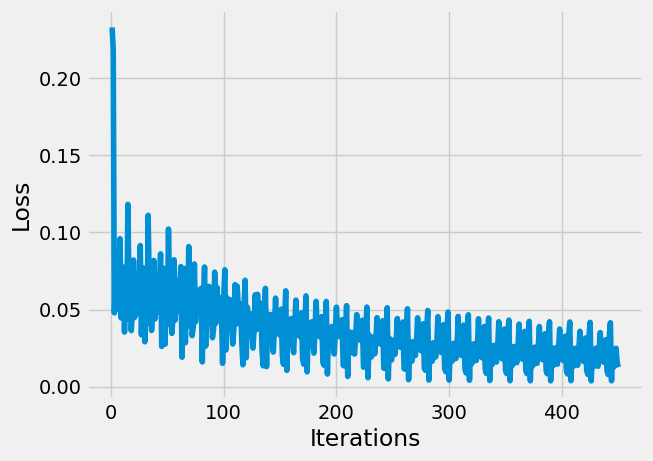

In [27]:
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Plotting the 1000 values
plt.plot([i+1 for i in range(int(len(losses)/1000))], losses[::1000])
plt.show()

In [28]:
torch.save(model.state_dict(), 'Autoencoder.pth')

I saved the model so I could use it on other day without running all cells again.

In [29]:
model = AutoEncoder()
model.load_state_dict(torch.load('Autoencoder.pth'))

<All keys matched successfully>

In [30]:
encoded_data = [model.encoder(X_ltrain[i]).detach().numpy() for i in range(len(X_ltrain))]

In [31]:
encoded_data

[array([ 8.057632  ,  5.215695  , -1.2830341 ,  0.44859582,  5.9817257 ,
         2.8178985 ,  0.24773681,  7.104256  ,  9.837033  ,  7.6764784 ,
         2.9629111 ,  4.168204  , -2.064757  ,  6.671608  ,  3.576742  ,
         2.6569483 ,  4.2374864 ,  7.3335605 ,  8.838337  ,  7.9872866 ,
         2.2770665 ,  5.57591   ,  5.642041  , -0.96587026,  5.1074166 ,
         6.583374  ,  5.2053013 ,  2.358586  ,  5.935821  ,  3.298177  ,
        -0.718881  ,  5.458179  ,  5.309582  , -2.4435484 ,  3.9841592 ,
         6.7046323 ], dtype=float32),
 array([ 2.1134377 ,  6.976833  , -1.5181167 , -1.0113815 ,  6.671393  ,
         4.5101075 ,  2.0649586 ,  1.1715124 , 12.755074  ,  9.660383  ,
         4.6392345 ,  1.8013588 , -2.653276  ,  4.620726  ,  8.250096  ,
         4.0186915 ,  7.663299  ,  0.9923877 ,  2.471721  , 10.498318  ,
         0.7079047 ,  6.5917754 ,  1.4801617 , -0.97502244, 14.496037  ,
         2.9885774 ,  2.909481  ,  3.8052382 ,  6.1785655 ,  8.247262  ,
         0.06

now we use 5-fold validation to find best haper parameters.

In [32]:
mlp_scores = np.zeros(12)
layers = [(100, 75), (100, 50), (75, 50)]
learning_rate = ['invscaling', 'adaptive']
activation = ['tanh', 'relu']
i = 0
for l in layers:         
    for learn in learning_rate:
        for a in activation:
            score = 0
            print("layer: " + str(l) + " ,learn: " + learn + " ,activation: " + a + " ,i: " + str(i+1))
            mlp = MLPClassifier(hidden_layer_sizes= l, learning_rate= learn , activation= a)
            score = cross_val_score(mlp, encoded_data, y_ltrain, cv=5)
            print("score: " + str(np.mean(score)))
            mlp_scores[i] = np.mean(score)
            i += 1

layer: (100, 75) ,learn: invscaling ,activation: tanh ,i: 1


c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


score: 0.9455555555555556
layer: (100, 75) ,learn: invscaling ,activation: relu ,i: 2


c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


score: 0.9443888888888889
layer: (100, 75) ,learn: adaptive ,activation: tanh ,i: 3


c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


score: 0.9437777777777778
layer: (100, 75) ,learn: adaptive ,activation: relu ,i: 4


c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


score: 0.9441111111111111
layer: (100, 50) ,learn: invscaling ,activation: tanh ,i: 5


c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


score: 0.9431666666666667
layer: (100, 50) ,learn: invscaling ,activation: relu ,i: 6


c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization

score: 0.9435555555555556
layer: (100, 50) ,learn: adaptive ,activation: tanh ,i: 7


c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


score: 0.9423333333333332
layer: (100, 50) ,learn: adaptive ,activation: relu ,i: 8


c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization

score: 0.9439444444444444
layer: (75, 50) ,learn: invscaling ,activation: tanh ,i: 9


c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization

score: 0.9407222222222222
layer: (75, 50) ,learn: invscaling ,activation: relu ,i: 10


c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization

score: 0.9397222222222222
layer: (75, 50) ,learn: adaptive ,activation: tanh ,i: 11


c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization

score: 0.9414999999999999
layer: (75, 50) ,learn: adaptive ,activation: relu ,i: 12


c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization

score: 0.9405000000000001


c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [33]:
mlp_scores

array([0.94555556, 0.94438889, 0.94377778, 0.94411111, 0.94316667,
       0.94355556, 0.94233333, 0.94394444, 0.94072222, 0.93972222,
       0.9415    , 0.9405    ])

In [34]:
mlp = MLPClassifier(hidden_layer_sizes= (100, 75, 50), learning_rate= 'invscaling' , activation= 'tanh')
score = cross_val_score(mlp, encoded_data, y_ltrain, cv=5)
print(np.mean(score))

0.944611111111111


calculate the accuracy on test data

In [35]:
encoded_test = [model.encoder(X_test[i]).detach().numpy() for i in range(len(X_test))]

mlp.fit(encoded_data, y_ltrain)

pickle.dump(mlp, open('mlp_model.pth', 'wb'))

y_predict = mlp.predict(encoded_test)

acc = accuracy_score(y_test, y_predict)
acc

0.9483

In [36]:
per_metrics = confusion_matrix(y_test, y_predict)
per_metrics

array([[ 967,    0,    1,    1,    2,    0,    6,    1,    1,    1],
       [   0, 1119,    1,    4,    1,    1,    4,    0,    4,    1],
       [   9,    5,  973,   14,    2,    2,    3,   10,   14,    0],
       [   0,    1,   14,  942,    0,   12,    0,   10,   21,   10],
       [   0,    2,    2,    0,  941,    1,    7,    2,    4,   23],
       [   3,    1,    1,   25,    3,  817,   11,    1,   18,   12],
       [   8,    4,    2,    0,    6,    7,  930,    0,    1,    0],
       [   1,    3,   15,    5,    4,    0,    1,  985,    2,   12],
       [   3,    1,   13,   22,    7,   25,    4,    5,  889,    5],
       [   5,    6,    1,    6,   42,    6,    0,   15,    8,  920]],
      dtype=int64)

calculate the accuracy on train data

In [16]:
encoded_test = [model.encoder(X_ltrain[i]).detach().numpy() for i in range(len(X_ltrain))]

y_predict = mlp.predict(encoded_test)

acc = accuracy_score(y_ltrain, y_predict)
acc

1.0

In [17]:
per_metrics = confusion_matrix(y_ltrain, y_predict)
per_metrics

array([[1777,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 2046,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 1804,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0, 1832,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0, 1715,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0, 1577,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 1769,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 1873,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 1791,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0, 1816]],
      dtype=int64)

In [7]:
model = AutoEncoder()
model.load_state_dict(torch.load('Autoencoder.pth'))

mlp = pickle.load(open('mlp_model.pth', 'rb'))

In [8]:
data = pd.read_csv("unlabeled_train_set.csv")
X = data.values

cluster the unlabeled data with 500 clusters.

In [9]:
# Create an instance of the KMeans class
kmeans = KMeans(n_clusters=500)

# Fit the model to your data
kmeans.fit(X)

# Obtain the cluster labels
labels = kmeans.labels_

# Access the cluster centers
cluster_centers = kmeans.cluster_centers_

c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [10]:
for i in range(500):
    print("number of digits in class"+ str(i) + ": "  + str(len(np.where(labels == i)[0])))

number of digits in class0: 46
number of digits in class1: 146
number of digits in class2: 118
number of digits in class3: 63
number of digits in class4: 112
number of digits in class5: 94
number of digits in class6: 69
number of digits in class7: 70
number of digits in class8: 114
number of digits in class9: 116
number of digits in class10: 165
number of digits in class11: 139
number of digits in class12: 71
number of digits in class13: 96
number of digits in class14: 83
number of digits in class15: 52
number of digits in class16: 76
number of digits in class17: 91
number of digits in class18: 76
number of digits in class19: 75
number of digits in class20: 119
number of digits in class21: 79
number of digits in class22: 58
number of digits in class23: 53
number of digits in class24: 115
number of digits in class25: 66
number of digits in class26: 101
number of digits in class27: 52
number of digits in class28: 65
number of digits in class29: 94
number of digits in class30: 81
number o

mapping 0-499 to 0-9 for clusters.

In [11]:
X_ultrain_test = scaler.transform(X)
nlabels = labels.copy()

for i in range(500):
    x = np.where(labels == i)
    rand = random.sample([j for j in range(len(x[0]))], 10)
    inp = np.array([X_ultrain_test[x[0][j]] for j in rand])
    tinp = torch.tensor(inp, dtype= torch.float32)
    encoded_out = [model.encoder(tinp[i]).detach().numpy() for i in range(10)]
    y_predict = mlp.predict(encoded_out)
    counts = np.bincount(y_predict)
    # Find the index of the maximum count
    most_common_value = np.argmax(counts)
    # print(most_common_value)
    for j in range(len(x[0])):
        nlabels[x[0][j]] = most_common_value + 500

In [12]:
nlabels -= 500

In [13]:
cs = np.zeros((10, 784))
for i in range(10):
    x = np.where(nlabels == i)
    s = np.zeros(784)
    for j in range(len(x[0])):
        s += X[x[0][j]]
    s = s/len(x[0])
    cs[i] = s

C:\Users\Asus\AppData\Local\Temp\ipykernel_12900\436026631.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


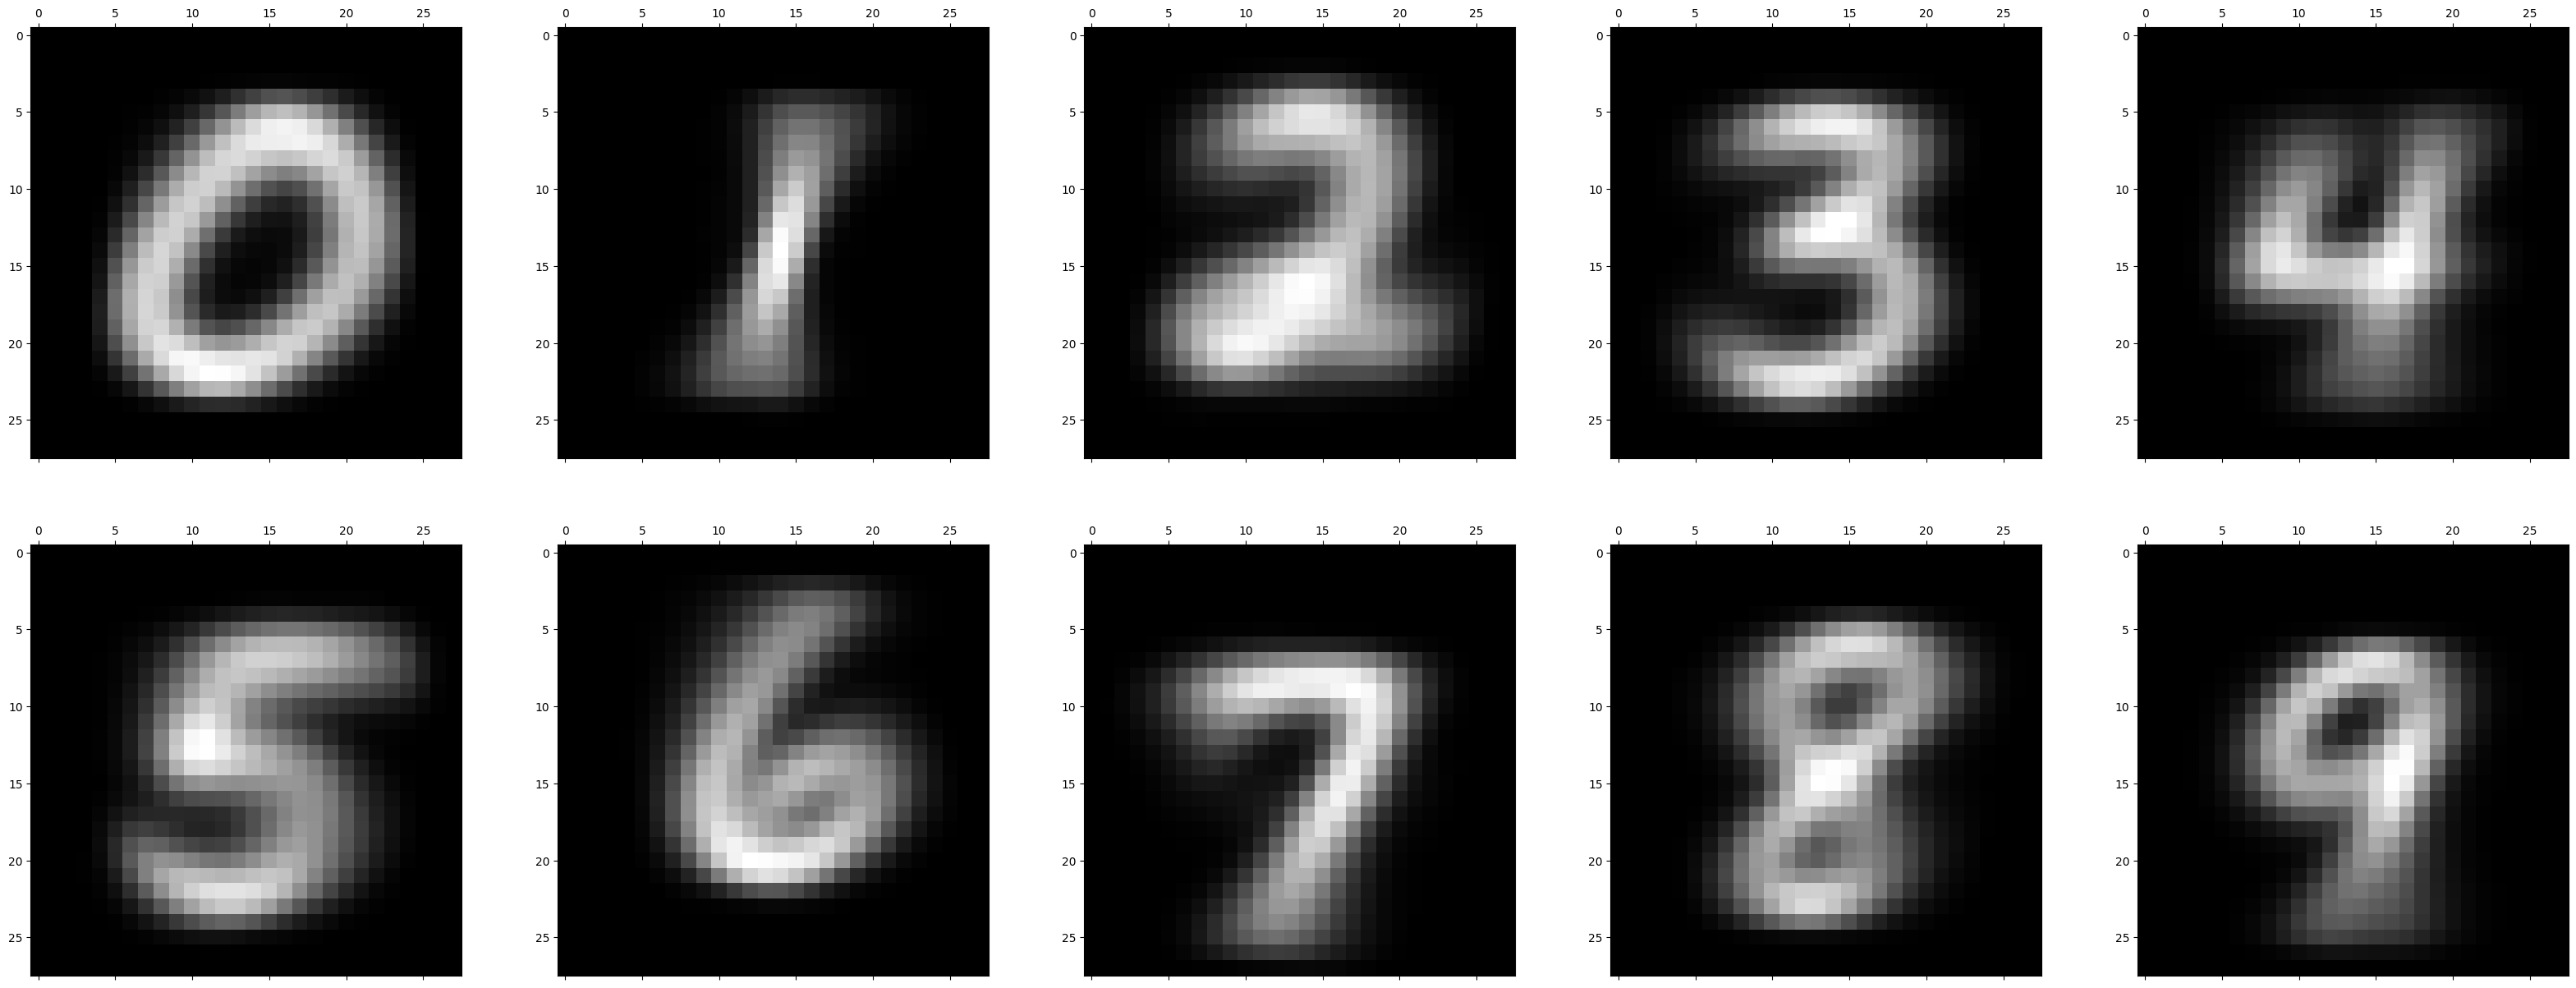

In [14]:
fig, axs = plt.subplots(2, 5, figsize=(40, 15))
plt.gray()
for i in range(10):
    center = cs[i]
    axs[i//5, i%5].matshow(center.reshape(28, 28))
fig.show()

combine labeled train data with labeled cluster

number of each digit.

In [15]:
for i in range(10):
    print("number of digits in class"+ str(i) + ": "  + str(len(np.where(nlabels == i)[0])))

number of digits in class0: 4160
number of digits in class1: 4805
number of digits in class2: 4394
number of digits in class3: 4161
number of digits in class4: 3884
number of digits in class5: 3994
number of digits in class6: 4247
number of digits in class7: 4237
number of digits in class8: 3740
number of digits in class9: 4378


In [16]:
new_X_train = torch.tensor(np.concatenate((X_ltrain.detach().numpy(), X_ultrain.detach().numpy())), dtype= torch.float32)
new_y_train = np.concatenate((y_ltrain, nlabels))

print(new_X_train.shape)
print(new_y_train.shape)

torch.Size([60000, 784])
(60000,)


In [17]:
encoded_train = [model.encoder(new_X_train[i]).detach().numpy() for i in range(len(new_X_train))]

mlp_model = MLPClassifier(hidden_layer_sizes= (100, 75, 50), learning_rate= 'invscaling' , activation= 'tanh')
score = cross_val_score(mlp_model, encoded_train, new_y_train, cv=5)
print(np.mean(score))

0.9259000000000001


c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [18]:
mlp_model.fit(encoded_train, new_y_train)

y_predict = mlp.predict(encoded_train)

acc = accuracy_score(new_y_train, y_predict)
acc

c:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.94395

In [19]:
per_metrics = confusion_matrix(new_y_train, y_predict)
per_metrics

array([[5821,    0,   16,    6,    2,   23,   27,    1,   35,    6],
       [   1, 6653,   16,   15,   28,   10,    9,   29,   46,   44],
       [   8,   43, 5753,   83,   36,   32,   23,  100,   99,   21],
       [  11,    2,   45, 5667,    3,  110,    3,    5,  117,   30],
       [   8,    5,   20,    5, 5347,   12,   10,   30,   24,  138],
       [  16,   11,    9,  155,   13, 5095,   40,   12,  186,   34],
       [  41,    7,   20,    4,   36,   44, 5813,   16,   30,    5],
       [   3,    7,   45,   21,   32,    8,    0, 5849,   24,  121],
       [   9,    6,   48,   90,   15,   66,   12,    3, 5248,   34],
       [   4,    8,   14,   15,  481,   16,    0,  211,   54, 5391]],
      dtype=int64)

In [20]:
new_X_test = torch.tensor(np.concatenate((X_test.detach().numpy(), X_ultrain.detach().numpy())), dtype= torch.float32)
new_y_test = np.concatenate((y_test, nlabels))

print(new_X_test.shape)
print(new_y_test.shape)

torch.Size([52000, 784])
(52000,)


In [21]:
encoded_test = [model.encoder(new_X_test[i]).detach().numpy() for i in range(len(new_X_test))]

y_predict = mlp_model.predict(encoded_test)

acc = accuracy_score(new_y_test, y_predict)
acc

0.9791923076923077

In [22]:
per_metrics = confusion_matrix(new_y_test, y_predict)
per_metrics

array([[5118,    0,    2,    2,    5,    4,    4,    2,    1,    2],
       [   0, 5915,    4,    2,    2,    2,    5,    3,    5,    2],
       [  15,   10, 5291,   38,    4,    3,    7,   32,   19,    7],
       [   1,    0,   13, 5078,    0,   33,    0,   10,   28,    8],
       [   3,    5,    5,    0, 4587,    4,   11,   11,    8,  232],
       [   6,    0,    5,   40,    1, 4782,   14,    3,   24,   11],
       [  14,    3,    5,    0,    6,    7, 5163,    2,    3,    2],
       [   0,    7,   23,    1,    4,    0,    0, 5152,    3,   75],
       [   9,    5,   17,   49,    5,   33,    4,    7, 4562,   23],
       [   4,    8,    2,    8,   32,    6,    1,   47,    9, 5270]],
      dtype=int64)